In [1]:
import torch
import pandas as pd
import numpy as np

rng = np.random.default_rng()

In [7]:
class SmartwatchDataset(torch.utils.data.Dataset):
    def __init__(self, valid_files, sample_period=0.02):
        """
        Parameters:
        -----------
        valid_files: list of filepaths to normalized data
        """
        super().__init__()
        self.data = []
        for file in valid_files:
            df = pd.read_csv(file)
            # Resample the data if needed
            df.index = pd.to_timedelta(df["time"], unit="seconds")
            df = df.drop("time", axis=1)
            df = df.resample(f"{sample_period}S").mean()
            self.data.append(df.values)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        """Returns tuple of (data, label) at index"""
        item = self.data[index]
        imu = item[:, 0:9]  # IMU sensor data [accel, mag, gyro]
        mocap = item[:, 9:]  # Mocap data [pos, quat]
        return imu, mocap

In [81]:
class SmartwatchAugment:
    """
    Collate function to apply random augmentations to the data
        - Randomly perturb the mocap positions
        - Randomly flip sign of mocap quaternion
        - Add random noise to IMU channels
    """
    def __init__(self, position_noise=0.2, accel_eps=0.01, gyro_eps=0.01, mag_eps=0.01, max_input_samples=512, downsample_output_seq=1):
        """
        Parameters:
        -----------
        position_noise: float, limits on uniform distribution [-p, p] to add position offset to mocap
        accel_eps: float, standard deviation on Gaussian noise added to accelerometer channels
        gyro_eps: float, standard deviation on Gaussian noise added to gyroscope channels
        mag_eps: float, standard deviation on Gaussian noise added to mangetometer channels
        max_input_samples: int, maximum number of input samples
        downsample_output_seq: int, factor to downsample output sequence
        """
        self.position_noise = position_noise
        self.accel_eps = accel_eps
        self.gyro_eps = gyro_eps
        self.mag_eps = mag_eps
        self.max_input_samples = max_input_samples
        self.downsample_output_seq = downsample_output_seq

    def _random_crop(self, imu, mocap):
        """
        Apply a random crop of the signal of length self.max_input_samples to both inputs and labels, if able to
        Due to targets being a shifted version of decoder inputs, we need to account for one extra timepoint (after downsampling)
        """
        n, d = imu.shape
        ds = self.downsample_output_seq
        cutoff = ds if n % ds == 0 else n % ds
        max_len = self.max_input_samples + ds
        max_offset = n - max_len

        if max_offset > 0:
            offset = rng.choice(max_offset)
            input_inds = slice(offset, offset + self.max_input_samples)
            output_inds = slice(offset, offset + max_len)
            imu, mocap = imu[input_inds, :], mocap[output_inds, :]
        else:
            cutoff = ds if n % ds == 0 else n % ds
            input_inds = slice(0, n - cutoff)
            imu = imu[input_inds, :]
        if self.downsample_output_seq > 1:
            mocap = mocap[::self.downsample_output_seq, :]
        return imu, mocap

    def __call__(self, data):
        """
        Parameters:
        -----------
        data: list of tuple of (imu, mocap) of length batch_size
            imu: np.ndarray, dimensions (n_samples, 9), signal data for IMU accel, gyro, and mag
            mocap: np.ndarray, dimensions (n_samples, 7), position and quaternion data from mocap

        Returns:
        --------
        collated_data: dict of torch.nn.utils.rnn.PackedSequence with keys ["encoder_inputs", "decoder_inputs", "targets"]
        """
        encoder_inputs = []
        decoder_inputs = []
        targets = []
        for (imu, mocap) in data:
            imu, mocap = self._random_crop(imu, mocap)

            n_in, d_in = imu.shape
            n_out, d_out = mocap.shape
            assert np.ceil(n_in / self.downsample_output_seq) + 1 == n_out, f"Downsamping failed, n_in={n_in}; n_out={n_out}"
            assert d_in == 9, f"IMU data has dimensionality {d_in} instead of 9"
            assert d_out == 7, f"Mocap data has dimensionality {d_out} instead of 7"

            # Augment XYZ positions
            offset = rng.uniform(-self.position_noise, self.position_noise, size=(1, 3))
            mocap[:, 0:3] += offset
            # Augment quaternion sign
            sign = rng.choice([-1, 1])
            mocap[:, 4:] *= sign

            accel_noise = rng.normal(loc=0, scale=self.accel_eps, size=(n_in, 3))
            gyro_noise = rng.normal(loc=0, scale=self.gyro_eps, size=(n_in, 3))
            mag_noise = rng.normal(loc=0, scale=self.mag_eps, size=(n_in, 3))

            noise = np.hstack([accel_noise, gyro_noise, mag_noise])
            imu += noise

            # Ensure targets are one timestep shifted wrt inputs
            encoder_inputs.append(torch.FloatTensor(imu))
            decoder_inputs.append(torch.FloatTensor(mocap[:-1, :]))
            targets.append(torch.FloatTensor(mocap[1:, :]))

        lengths = [len(item) for item in encoder_inputs]
        inds = np.flip(np.argsort(lengths)).copy()  # PackedSequence expects lengths from longest to shortest
        lengths = torch.LongTensor(lengths)[inds]

        # Sort by lengths
        encoder_inputs = [encoder_inputs[i] for i in inds]
        decoder_inputs = [decoder_inputs[i] for i in inds]
        targets = [targets[i] for i in inds]

        # encoder_inputs = torch.nn.utils.rnn.pack_sequence(encoder_inputs)
        # decoder_inputs = torch.nn.utils.rnn.pack_sequence(decoder_inputs)
        # targets = torch.nn.utils.rnn.pack_sequence(targets)
        collated_data = {
            "encoder_inputs": encoder_inputs,
            "decoder_inputs": decoder_inputs,
            "targets": targets
        }
        return collated_data


In [52]:
np.arange(1024+3)[::3].shape

(343,)

In [58]:
np.arange(15)[slice(0, 10)].size // 3

3

In [59]:
np.arange(15)[slice(0, 13, 3)]

array([ 0,  3,  6,  9, 12])

# Test dataset class

In [3]:
import glob
valid_files = glob.glob("/root/data/smartwatch/subjects/*/*_full.csv")
len(valid_files)

655

In [4]:
test_subjects = [f"S{n}" for n in [5, 10, 15, 20, 25, 30]]
test_files = [file for file in valid_files for subject in test_subjects if f"/{subject}/" in file]
train_files = [file for file in valid_files if file not in set(test_files)]

In [5]:
len(test_files), len(train_files)

(79, 576)

In [8]:
dataset = SmartwatchDataset(valid_files)

In [90]:
collator = SmartwatchAugment(max_input_samples=1024, downsample_output_seq=2)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, collate_fn=collator)

In [91]:
for batch in dataloader:
    for enc, dec, tgt in zip(*batch.values()):
        print(enc.shape, dec.shape, tgt.shape)

torch.Size([1024, 9]) torch.Size([512, 7]) torch.Size([512, 7])
torch.Size([1024, 9]) torch.Size([512, 7]) torch.Size([512, 7])
torch.Size([1024, 9]) torch.Size([512, 7]) torch.Size([512, 7])
torch.Size([1024, 9]) torch.Size([512, 7]) torch.Size([512, 7])
torch.Size([1024, 9]) torch.Size([512, 7]) torch.Size([512, 7])
torch.Size([1024, 9]) torch.Size([512, 7]) torch.Size([512, 7])
torch.Size([1024, 9]) torch.Size([512, 7]) torch.Size([512, 7])
torch.Size([1024, 9]) torch.Size([512, 7]) torch.Size([512, 7])
torch.Size([1024, 9]) torch.Size([512, 7]) torch.Size([512, 7])
torch.Size([1024, 9]) torch.Size([512, 7]) torch.Size([512, 7])
torch.Size([1024, 9]) torch.Size([512, 7]) torch.Size([512, 7])
torch.Size([1024, 9]) torch.Size([512, 7]) torch.Size([512, 7])
torch.Size([1024, 9]) torch.Size([512, 7]) torch.Size([512, 7])
torch.Size([1024, 9]) torch.Size([512, 7]) torch.Size([512, 7])
torch.Size([1024, 9]) torch.Size([512, 7]) torch.Size([512, 7])
torch.Size([1024, 9]) torch.Size([512, 7

In [14]:
dec[0][:3, 0], tgt[0][:3, 0]

(tensor([-0.7261, -0.7642, -0.8087]), tensor([-0.7642, -0.8087, -0.8533]))

In [15]:
from torch import nn

In [16]:
lstm = nn.LSTM(input_size=9, hidden_size=32, batch_first=True)

In [17]:
batch = {k: torch.nn.utils.rnn.pack_sequence(v) for k, v in batch.items()}

outputs = lstm(batch["encoder_inputs"])

In [18]:
output, (hidden, cell) = outputs
output.data.shape

torch.Size([8192, 32])

# Examples

In [ ]:
# To have 512 input, 512 output at 50 Hz use:

dataset = SmartwatchDataset(valid_files)  # Defaults to 50Hz
collator = SmartwatchAugment(max_input_samples=512, downsample_output_seq=1)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, collate_fn=collator)

In [ ]:
# To have 512 input, 512 output at 25 Hz use:

dataset = SmartwatchDataset(valid_files, sample_period=0.04)
collator = SmartwatchAugment(max_input_samples=512, downsample_output_seq=1)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, collate_fn=collator)

In [ ]:
# To have 1024 input at 50Hz and 512 output at 25Hz use:

dataset = SmartwatchDataset(valid_files)
collator = SmartwatchAugment(max_input_samples=1024, downsample_output_seq=2)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, collate_fn=collator)

# Estimating noise in IMU inputs

In [95]:
import matplotlib.pyplot as plt

imu = batch["encoder_inputs"][0]

In [127]:
imu, mocap = dataset[0]
n_in = 1024

accel = imu[:n_in, 0:3]
gyro = imu[:n_in, 3:6]
mag = imu[:n_in, 6:]

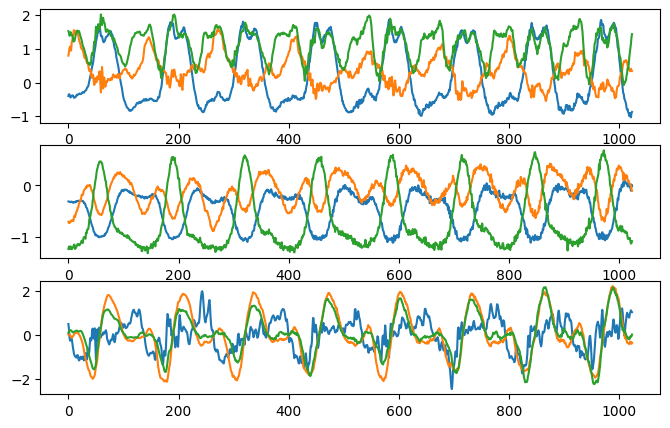

In [128]:
fig, axs = plt.subplots(3, 1, figsize=(8, 5))
for ax, data in zip(axs, [accel, gyro, mag]):
    for i in range(3):
        ax.plot(data[:, i])

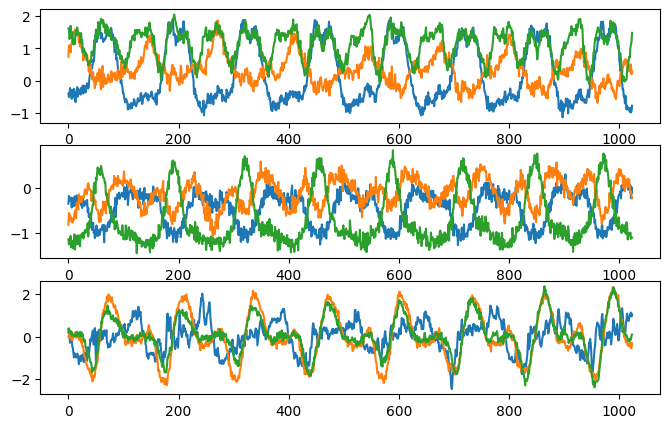

In [141]:
accel_eps = gyro_eps = mag_eps = 0.1
rng = np.random.default_rng()

accel_noise = rng.normal(loc=0, scale=accel_eps, size=(n_in, 3))
gyro_noise = rng.normal(loc=0, scale=gyro_eps, size=(n_in, 3))
mag_noise = rng.normal(loc=0, scale=mag_eps, size=(n_in, 3))

accel_noisy = accel + accel_noise
gyro_noisy = gyro + gyro_noise
mag_noisy = mag + mag_noise

fig, axs = plt.subplots(3, 1, figsize=(8, 5))
for ax, data in zip(axs, [accel_noisy, gyro_noisy, mag_noisy]):
    for i in range(3):
        ax.plot(data[:, i])